<h1>A Project on Breast Cancer Diagnostics - To get certain insights</h1>

### Import Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load our Dataset

bc_dataset = pd.read_csv("Breast_Cancer.csv", encoding = "ISO-8859-1")

In [3]:
#Let's inspect our data and get a feel of what we are working with
print(bc_dataset.head())
print(bc_dataset.tail())

   Age   Race Marital Status T Stage  N Stage 6th Stage  \
0   68  White        Married       T1      N1       IIA   
1   50  White        Married       T2      N2      IIIA   
2   58  White       Divorced       T3      N3      IIIC   
3   58  White        Married       T1      N1       IIA   
4   47  White        Married       T2      N1       IIB   

               differentiate Grade   A Stage  Tumor Size Estrogen Status  \
0      Poorly differentiated     3  Regional           4        Positive   
1  Moderately differentiated     2  Regional          35        Positive   
2  Moderately differentiated     2  Regional          63        Positive   
3      Poorly differentiated     3  Regional          18        Positive   
4      Poorly differentiated     3  Regional          41        Positive   

  Progesterone Status  Regional Node Examined  Reginol Node Positive  \
0            Positive                      24                      1   
1            Positive                      1

In [4]:
#Let's get the column names and export to chatgpt to get an understanding of the data we are working with

bc_dataset.columns

Index(['Age', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

In [5]:
#before we dig deep.., let's just drop some columns. some columns that would be dropped are based on the following assumptions:
# Marital Status: Assume all women have similar status and relationship life is not a contributing factor
#Race: Assume all women belong to the same race. i.e. a homogenous race in this regards
#A stage: Essentially most of the A stages here are regional

In [6]:
bc_dataset_cp = bc_dataset.copy(deep = True)

In [7]:
bc_dataset_cp.drop(['Race', 'Marital Status', 'A Stage'], axis = 1, inplace= True)

In [8]:
#before we continue..., are there any loopholes in our dataset
#i mean is any null value present

In [9]:
bc_dataset_cp.isnull().sum()
#alright.., no null values present.., it's clean.., we can proceed

Age                       0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

In [10]:
#feature-engineering --- for the sake of this transformation.., we want to convert the status to 1 for alive and 0 for dead
#this extra column would be necessary for machine learning., as text might be intrinsically confusing

bc_dataset_cp.Status.unique()

#alright.., with this we can write a lambda function for mapping Alive to 1 and Dead to 0

status_converter = lambda x: 1 if x == 'Alive' else 0

In [11]:
bc_dataset_cp['status_in_digits'] = bc_dataset_cp['Status'].map(status_converter)

In [12]:
bc_dataset_cp.columns

Index(['Age', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade',
       'Tumor Size', 'Estrogen Status', 'Progesterone Status',
       'Regional Node Examined', 'Reginol Node Positive', 'Survival Months',
       'Status', 'status_in_digits'],
      dtype='object')

In [13]:
#column names modification
#let's use underscore for spaces
#let's swap case from sentence case to lower cse

bc_dataset_cp.rename(columns= {'Age':'age', 'T Stage ':'t_stage','N Stage':'n_stage', '6th Stage':'6th_stage',
                               'Grade':'grade', 'Tumor Size':'tumor_size', 'Estrogen Status':'estrogen_status',
                               'Progesterone Status':'progesterone_status', 'Regional Node Examined':'regional_node_examined',
                               'Reginol Node Positive':'regional_node_positive', 'Survival Months':'survival_months',
                               'Status':'status'}, inplace = True)

In [14]:
bc_dataset_cp.columns

Index(['age', 't_stage', 'n_stage', '6th_stage', 'differentiate', 'grade',
       'tumor_size', 'estrogen_status', 'progesterone_status',
       'regional_node_examined', 'regional_node_positive', 'survival_months',
       'status', 'status_in_digits'],
      dtype='object')

In [15]:
#let's not get too ahead of ourselves.., but we can take a look at the data types that are numbers and see if there is 
#any correlation between them

In [16]:
corr_values_numeric= (bc_dataset_cp[(bc_dataset_cp.columns[bc_dataset_cp.dtypes == 'int64'])]).corr()
#from what i can see it seems there isn't any relationship.., we can employ the heatmap of seaborn to visualize this

corr_values_numeric

,age,tumor_size,regional_node_examined,regional_node_positive,survival_months,status_in_digits
age,1.000000,-0.077215,-0.033345,0.012586,-0.009390,-0.055921
tumor_size,-0.077215,1.000000,0.104352,0.242322,-0.086901,-0.134205
regional_node_examined,-0.033345,0.104352,1.000000,0.411580,-0.022054,-0.034772
regional_node_positive,0.012586,0.242322,0.411580,1.000000,-0.135214,-0.256638
survival_months,-0.009390,-0.086901,-0.022054,-0.135214,1.000000,0.476514
status_in_digits,-0.055921,-0.134205,-0.034772,-0.256638,0.476514,1.000000


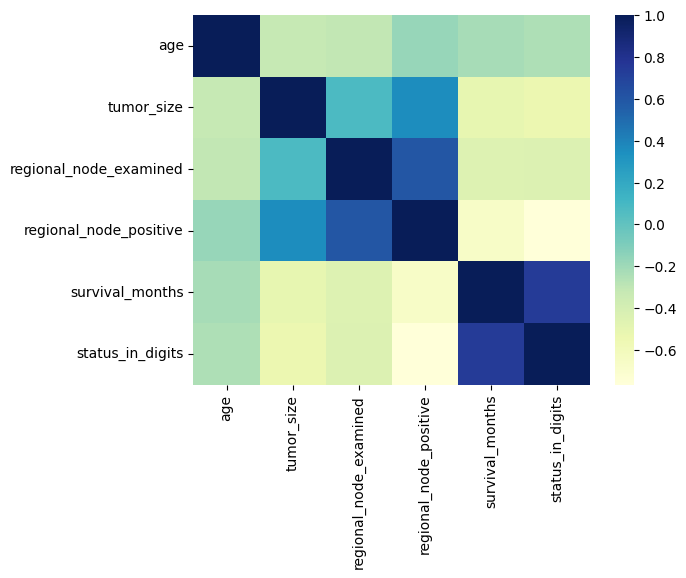

In [17]:
sns.heatmap(data = corr_values_numeric.corr(), cmap = 'YlGnBu')
plt.show()


#observations: it's quite obvious: but we know that there is a correlation somewhere around 0.5 with the survival months
#this might be misleading as the status is not dead.., let's reevaluate for a status of dead and see what our results tells us

<Axes: xlabel='status_in_digits', ylabel='count'>

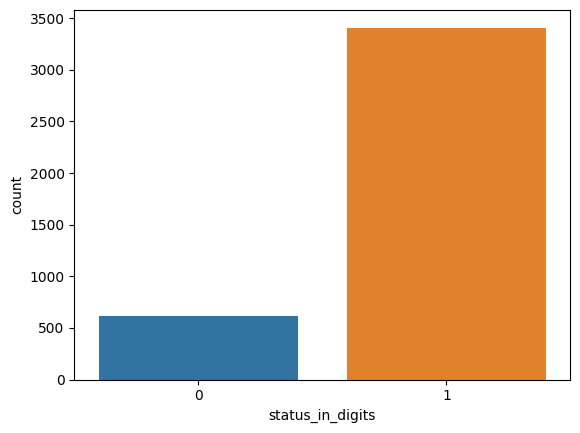

In [18]:
#alright.., let's start with status and survival months...
#let's see a count plot of this

sns.countplot(data = bc_dataset_cp, x= 'status_in_digits')

In [19]:
bc_dataset_cp.groupby('status_in_digits')['survival_months'].sum()

status_in_digits
0     28096
1    258807
Name: survival_months, dtype: int64

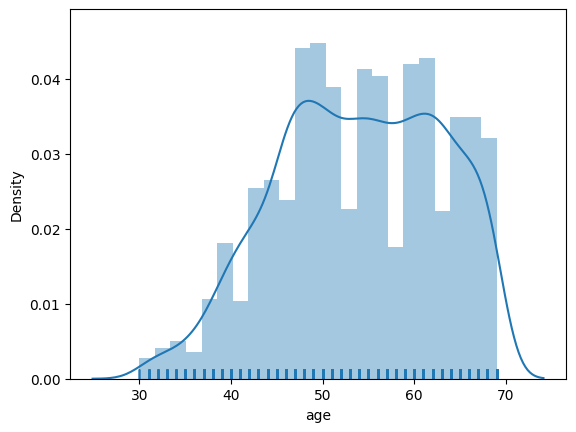

In [20]:
#alright.., what age distribution of women am i working with
#let's take a look at the age distribution using seaborn's distplot

fig = plt.figure()

ax1 = fig.add_subplot(111)

sns.distplot(bc_dataset_cp['age'], ax = ax1, rug = True)

fig.show()

In [21]:
bins_age = [30, 40, 50, 60, 70] 

In [22]:
bc_dataset_cp['binned_age'] = pd.cut(bc_dataset_cp['age'], bins_age, labels= ['30-40', '40-50', '50-60', '60+'])

In [23]:
bc_dataset_cp.groupby('binned_age')['age'].count()

#observation is that the age bracket of women in this analysis is mostly in the 40-50, 50-60 and 60+ regions.., especially
#maximum concentration in the 50-60 region

binned_age
30-40     297
40-50    1196
50-60    1386
60+      1140
Name: age, dtype: int64

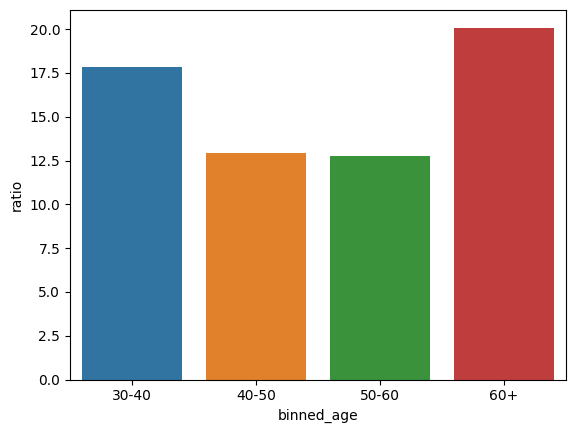

In [24]:
#what age bracket has the highest death rate
#let's see the ratio of deaths

a = pd.crosstab(bc_dataset_cp.binned_age, bc_dataset_cp.status_in_digits)
a['ratio'] = round((a[0]/(a[0] + a[1]))*100, 2)
sns.barplot(data = a, x = a.index, y = a['ratio'])
plt.show()

In [25]:
bc_dataset_cp.columns

Index(['age', 't_stage', 'n_stage', '6th_stage', 'differentiate', 'grade',
       'tumor_size', 'estrogen_status', 'progesterone_status',
       'regional_node_examined', 'regional_node_positive', 'survival_months',
       'status', 'status_in_digits', 'binned_age'],
      dtype='object')

<Axes: xlabel='tumor_size'>

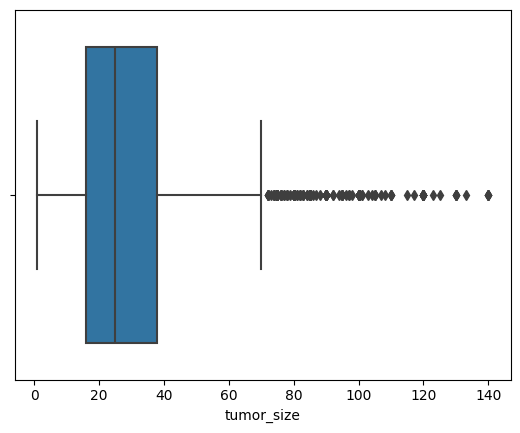

In [26]:
#alright.., let's get the boxplot of the cancer stages
sns.boxplot(data = bc_dataset_cp, x = 'tumor_size')

In [27]:
#let's investigate something....
#people that died what was the average tumor size.., against those that are still living.., if there is any relationship

bc_dataset_cp.groupby('status_in_digits')['tumor_size'].mean()

status_in_digits
0    37.139610
1    29.268779
Name: tumor_size, dtype: float64

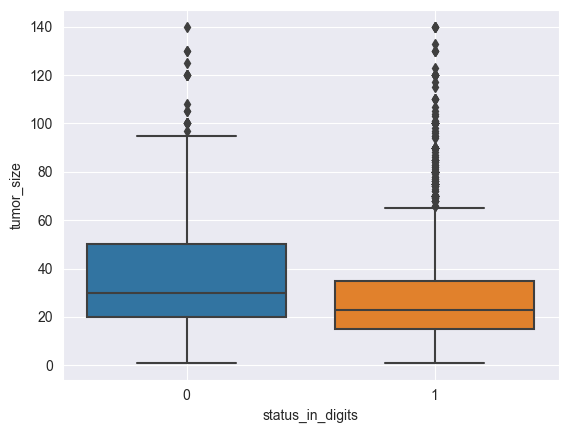

In [28]:
#let's see a boxplot of this.., let's know if the abnormal tumor sizes could contribute to death factors.., alright
#let's take a detailed look

fig = plt.figure()
sns.set_style('dark')
sns.boxplot(data = bc_dataset_cp, y='tumor_size', x = 'status_in_digits')
plt.grid()
fig.show()


#observation: although there are several outliers in both dead and alive
#those that died the tumor size in most of the distributions were higher
#next stop let's just use only 95% of the population in both cases and plot to see how the boxplot looks like

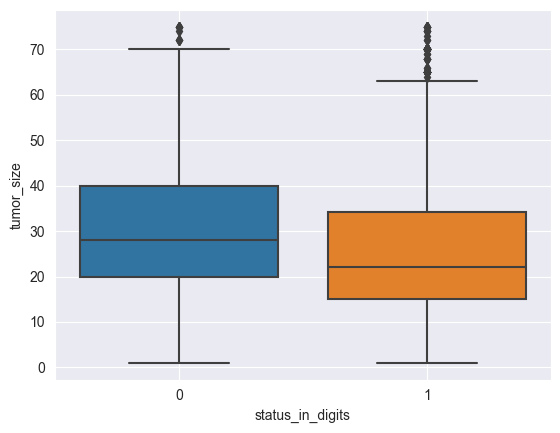

In [29]:
top_95 = round(bc_dataset_cp.shape[0] * 0.95)
top_95_bc_dataset_cp = bc_dataset_cp.sort_values(by = 'tumor_size').head(top_95)

fig = plt.figure()
sns.set_style('dark')
sns.boxplot(data =top_95_bc_dataset_cp, y='tumor_size', x = 'status_in_digits')
plt.grid()
fig.show()

#we now get a good understanding of what our dataset is all about

In [30]:
#is there any relationship between tumor size and age?
#how does tumor size vary with age in the entire distribution for both dead and alive.., we can see the mean

alive_tumor = bc_dataset_cp[bc_dataset_cp.status_in_digits == 1].groupby('binned_age')['tumor_size'].mean().reset_index()
alive_tumor.rename(columns = {'tumor_size':'tumor_size_alive'}, inplace = True)
dead_tumor = bc_dataset_cp[bc_dataset_cp.status_in_digits == 0].groupby('binned_age')['tumor_size'].mean().reset_index()
dead_tumor.rename(columns = {'tumor_size':'tumor_size_dead'}, inplace = True)

full_tumor = pd.merge(alive_tumor, dead_tumor, on = 'binned_age')

full_tumor

#relationship the mean tumor size of those that died are actually higher than those that are alive.. so we can conclude that
#tumor sizes are responsible for death..

#but let's see it in a boxplot just to be sure that outliers are not affecting our distribution

,binned_age,tumor_size_alive,tumor_size_dead
0,30-40,31.819672,49.886792
1,40-50,31.140250,37.574194
2,50-60,28.909016,35.858757
3,60+,26.952799,34.532751


<Axes: xlabel='binned_age', ylabel='tumor_size'>

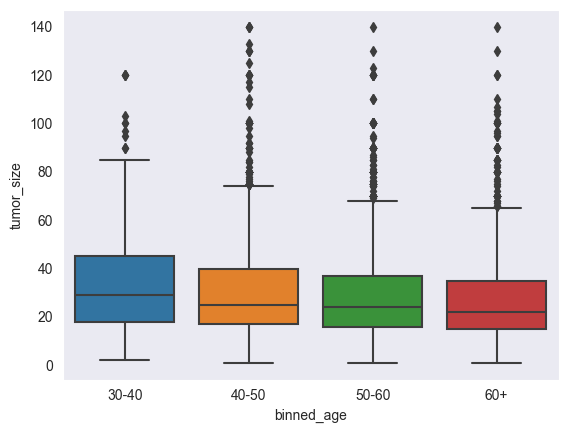

In [31]:
sns.boxplot(data = bc_dataset_cp, x = 'binned_age', y = 'tumor_size')

#from this boxplot .., outliers are much.., but let's observe the outliers.., do they always lead to date cases.., alright., let's investigate

In [32]:
bc_dataset_cp.sort_values(by = 'tumor_size', ascending= False)[['tumor_size', 'status_in_digits']].head(10).groupby('status_in_digits').count()

#so from this we can conclude that outlies tumor sizes.., didn't really contribute to the death rate

,tumor_size
status_in_digits,
0,3
1,7


In [33]:
#let's take a look at the survival months to see if it relates to the status dead or alive

count    4024.000000
mean       71.297962
std        22.921430
min         1.000000
25%        56.000000
50%        73.000000
75%        90.000000
max       107.000000
Name: survival_months, dtype: float64


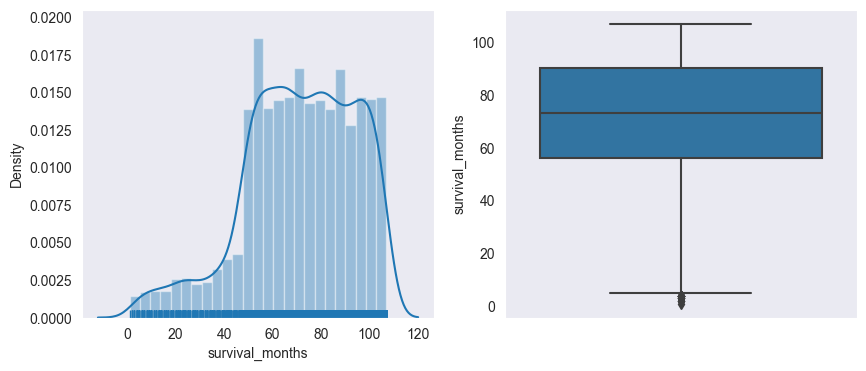

In [34]:
#can we see how the survival months are distributed alright
print(bc_dataset_cp.survival_months.describe())


fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(121)
sns.distplot(bc_dataset_cp['survival_months'], rug = True, ax = ax1)
ax2 = fig.add_subplot(122)
sns.boxplot(data = bc_dataset_cp, y = 'survival_months', ax = ax2)
fig.show()

In [35]:
#let's take a look at the stages.., and discover at what stage is someone most likely to die


for column in bc_dataset_cp.columns:
    if 'stage' in column:
        print(bc_dataset_cp[column].unique())

['T1' 'T2' 'T3' 'T4']
['N1' 'N2' 'N3']
['IIA' 'IIIA' 'IIIC' 'IIB' 'IIIB']


In [36]:
#what can we do to this
#for the T stages let's see the death rate using a count plot for all the stages

print("Death Table")
print(bc_dataset_cp[bc_dataset_cp.status_in_digits == 0].groupby(['t_stage', 'n_stage', '6th_stage'])['status_in_digits'].count().unstack().fillna(0))

print("\n\n------------------------------------\nAlive Table")


print(bc_dataset_cp[bc_dataset_cp.status_in_digits == 1].groupby(['t_stage', 'n_stage', '6th_stage'])['status_in_digits'].count().unstack().fillna(0))


#observation: majority of the people that died cancer was at stage T2 and N1, followed by stage T1 and N1

Death Table
6th_stage         IIA    IIB  IIIA  IIIB  IIIC
t_stage n_stage                               
T1      N1       96.0    0.0   0.0   0.0   0.0
        N2        0.0    0.0  31.0   0.0   0.0
        N3        0.0    0.0   0.0   0.0  30.0
T2      N1        0.0  135.0   0.0   0.0   0.0
        N2        0.0    0.0  88.0   0.0   0.0
        N3        0.0    0.0   0.0   0.0  80.0
T3      N1        0.0    0.0  31.0   0.0   0.0
        N2        0.0    0.0  34.0   0.0   0.0
        N3        0.0    0.0   0.0   0.0  51.0
T4      N1        0.0    0.0   0.0   8.0   0.0
        N2        0.0    0.0   0.0  12.0   0.0
        N3        0.0    0.0   0.0   0.0  20.0


------------------------------------
Alive Table
6th_stage           IIA    IIB   IIIA  IIIB   IIIC
t_stage n_stage                                   
T1      N1       1209.0    0.0    0.0   0.0    0.0
        N2          0.0    0.0  180.0   0.0    0.0
        N3          0.0    0.0    0.0   0.0   57.0
T2      N1          0.0 

In [37]:
#alright.., next we want to see the various stages of the T, the N, the 6

#let's get the data for all  this

t_stage_data = pd.crosstab(bc_dataset_cp.t_stage, bc_dataset_cp.status_in_digits)
t_stage_data['death_ratio'] = round((t_stage_data[0]/(t_stage_data[0] + t_stage_data[1]))*100)

n_stage_data = pd.crosstab(bc_dataset_cp.n_stage, bc_dataset_cp.status_in_digits)
n_stage_data['death_ratio'] = round((n_stage_data[0]/(n_stage_data[0] + n_stage_data[1]))*100)


six_stage_data = pd.crosstab(bc_dataset_cp['6th_stage'], bc_dataset_cp.status_in_digits)
six_stage_data['death_ratio'] = round((six_stage_data[0]/(six_stage_data[0] + six_stage_data[1]))*100)


print(t_stage_data)
print('\n-------------------------------------------------------------')

print(n_stage_data)
print('\n---------------------------------------------------------------')

print(six_stage_data)

status_in_digits    0     1  death_ratio
t_stage                                 
T1                157  1446         10.0
T2                303  1483         17.0
T3                116   417         22.0
T4                 40    62         39.0

-------------------------------------------------------------
status_in_digits    0     1  death_ratio
n_stage                                 
N1                270  2462         10.0
N2                165   655         20.0
N3                181   291         38.0

---------------------------------------------------------------
status_in_digits    0     1  death_ratio
6th_stage                               
IIA                96  1209          7.0
IIB               135   995         12.0
IIIA              184   866         18.0
IIIB               20    47         30.0
IIIC              181   291         38.0


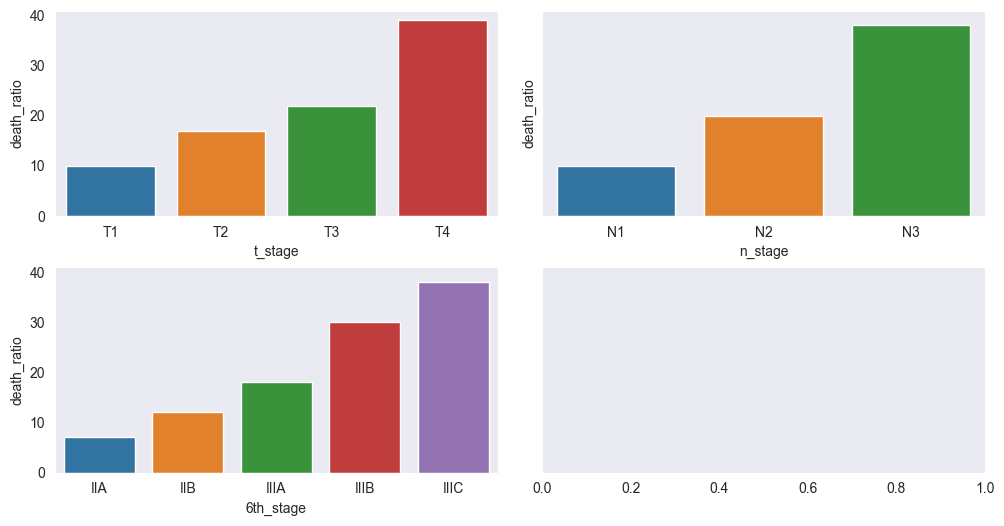

In [38]:
#let's visualise this

fig, axes = plt.subplots(2,2, sharey= True, figsize = (12, 6))

sns.barplot(data = t_stage_data, x = t_stage_data.index, y = 'death_ratio', ax = axes[0,0])
sns.barplot(data = n_stage_data, x = n_stage_data.index, y = 'death_ratio', ax= axes[0,1])
sns.barplot(data = six_stage_data, x = six_stage_data.index, y = 'death_ratio', ax = axes[1,0])

plt.subplots_adjust(wspace = 0.1, hspace = 0.25)

plt.show()
# axes[0,0] = sns.barplot(data = t_stage_data, x = t_stage_data.index, y = 'death_ratio')


#observation: majority of people died in the highest stage of cancer
#which is obvious though

In [39]:
#let's look at other columns.., estrogen and progesterone or so


bc_dataset_cp.columns

Index(['age', 't_stage', 'n_stage', '6th_stage', 'differentiate', 'grade',
       'tumor_size', 'estrogen_status', 'progesterone_status',
       'regional_node_examined', 'regional_node_positive', 'survival_months',
       'status', 'status_in_digits', 'binned_age'],
      dtype='object')

In [40]:
print(bc_dataset_cp.groupby('estrogen_status')['estrogen_status'].count())
print('\n\n---------------------------------------------------\n================================\n')
print(bc_dataset_cp.groupby('estrogen_status')['survival_months'].mean())

estrogen_status
Negative     269
Positive    3755
Name: estrogen_status, dtype: int64


---------------------------------------------------

estrogen_status
Negative    60.297398
Positive    72.086019
Name: survival_months, dtype: float64


estrogen_status
Negative    72.023697
Positive    74.375138
Name: survival_months, dtype: float64




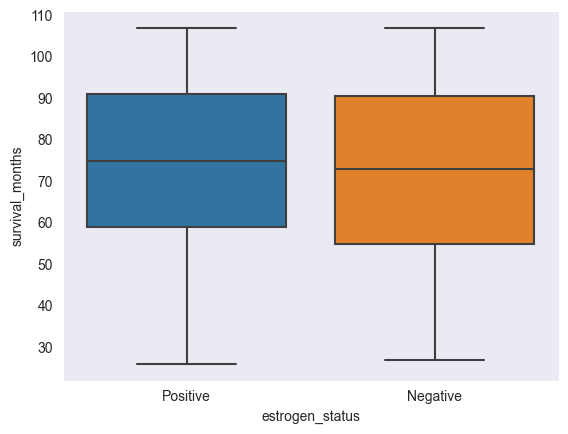

In [41]:
sns.boxplot(data = bc_dataset_cp.sort_values(by = 'survival_months', ascending = False).head(top_95), 
            x = 'estrogen_status', y = 'survival_months')


print(bc_dataset_cp.sort_values(by = 'survival_months', ascending = False).head(top_95).groupby('estrogen_status')['survival_months'].mean())
print('\n')

#the estrogen status have no relationship with dead or alive..

In [42]:
#let's check the progresterone status

bc_dataset_cp.progesterone_status.unique()

array(['Positive', 'Negative'], dtype=object)

<Axes: >

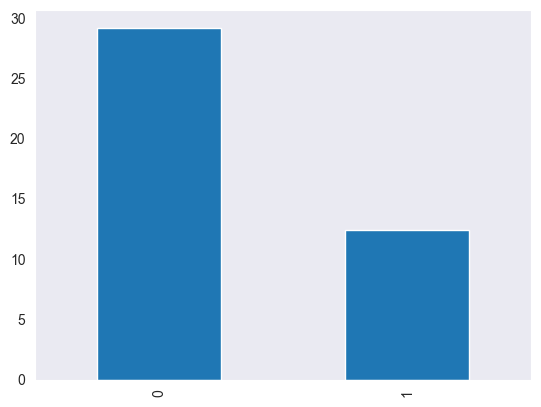

In [43]:
a = pd.crosstab(bc_dataset_cp.progesterone_status, bc_dataset_cp.status).reset_index()

a['dead_percentage'] = round((a['Dead']/(a['Dead'] + a['Alive'])) * 100, 2)

a['dead_percentage'].plot(kind = 'bar')

#so, we see that the percentage of the negatives is quite high, as compared to positive .., let's pick it

In [45]:
bc_dataset_cp.head(3)

,age,t_stage,n_stage,6th_stage,differentiate,grade,tumor_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,survival_months,status,status_in_digits,binned_age
0,68,T1,N1,IIA,Poorly differentiated,3,4,Positive,Positive,24,1,60,Alive,1,60+
1,50,T2,N2,IIIA,Moderately differentiated,2,35,Positive,Positive,14,5,62,Alive,1,40-50
2,58,T3,N3,IIIC,Moderately differentiated,2,63,Positive,Positive,14,7,75,Alive,1,50-60


In [46]:
bc_dataset_cp['regional_node_bins'] = pd.cut(bc_dataset_cp.regional_node_positive, labels= ['1-11', '11-21', '21-31', '31-41', '41+'], bins = 5)

In [47]:
f = pd.crosstab(bc_dataset_cp['regional_node_bins'], bc_dataset_cp['status_in_digits']) #let's see the percentage of those that are dead, for each category of regional nodes
f['death_ratio'] =round((f[0]/(f[0] + f[1]))*100, 2)

<Axes: xlabel='regional_node_bins'>

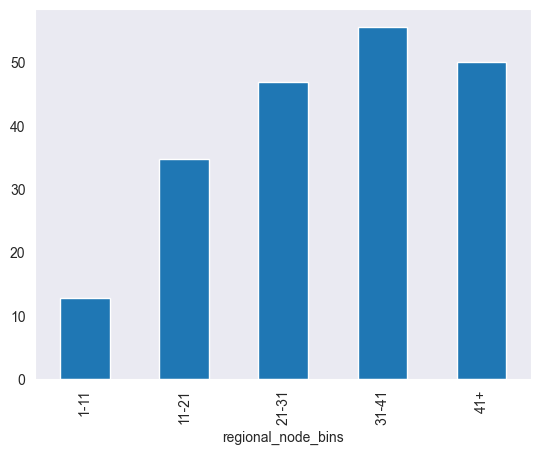

In [48]:
f['death_ratio'].plot(kind = 'bar')

#I just see that, as the regional nodes increase you are more likely to die

In [49]:
bc_dataset_cp.grade.unique() #alright.., let's see if there is a relationship for this grade alright

array(['3', '2', '1', ' anaplastic; Grade IV'], dtype=object)

In [50]:
bc_dataset_cp.grade = bc_dataset_cp.grade.apply(lambda x: 4 if x == ' anaplastic; Grade IV' else x)

In [51]:
bc_dataset_cp.grade = bc_dataset_cp.grade.astype(int)

<Axes: xlabel='grade'>

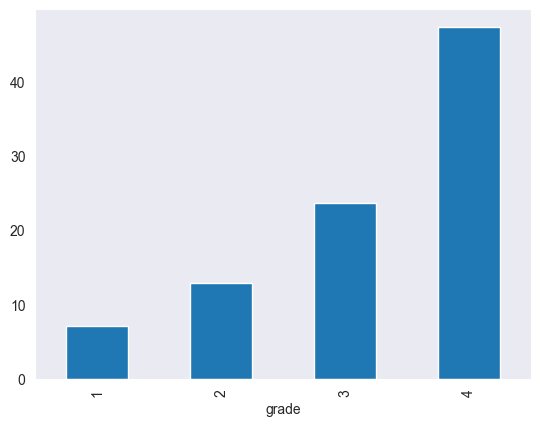

In [52]:
#let's get the crosstab of this

g = pd.crosstab(bc_dataset_cp.grade, bc_dataset_cp.status_in_digits)

g['ratio_of_death'] = round(((g[0])/(g[0]+g[1]))* 100, 2)

g['ratio_of_death'].plot(kind = 'bar')

#alright.., so grade is a clear indicator

## MACHINE LEARNING FOR THIS DATA

In [53]:
bc_dataset_cp.head(2)

,age,t_stage,n_stage,6th_stage,differentiate,grade,tumor_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,survival_months,status,status_in_digits,binned_age,regional_node_bins
0,68,T1,N1,IIA,Poorly differentiated,3,4,Positive,Positive,24,1,60,Alive,1,60+,1-11
1,50,T2,N2,IIIA,Moderately differentiated,2,35,Positive,Positive,14,5,62,Alive,1,40-50,1-11


In [54]:
#let's drop some columns and focus on the others

columns_to_drop = ['differentiate', 'estrogen_status', 'regional_node_examined', 'survival_months', 'status', 'binned_age', 'regional_node_bins']

In [55]:
bc_dataset_cp.drop(columns_to_drop, axis = 1, inplace = True)

In [56]:
bc_dataset_cp.head(3)

,age,t_stage,n_stage,6th_stage,grade,tumor_size,progesterone_status,regional_node_positive,status_in_digits
0,68,T1,N1,IIA,3,4,Positive,1,1
1,50,T2,N2,IIIA,2,35,Positive,5,1
2,58,T3,N3,IIIC,2,63,Positive,7,1


In [57]:
#alright.., let's make the progesterone_status be 1 for positive and 0 for negative

bc_dataset_cp['progesterone_status'] = bc_dataset_cp['progesterone_status'].apply(lambda x: 1 if x == 'Positive' else 0)

In [58]:
bc_dataset_cp.progesterone_status.unique()

array([1, 0], dtype=int64)

In [59]:
#let's use a column transformer to transform the columns that need to be numerical alright, before that we have to label encode them

bc_dataset_cp.head()

,age,t_stage,n_stage,6th_stage,grade,tumor_size,progesterone_status,regional_node_positive,status_in_digits
0,68,T1,N1,IIA,3,4,1,1,1
1,50,T2,N2,IIIA,2,35,1,5,1
2,58,T3,N3,IIIC,2,63,1,7,1
3,58,T1,N1,IIA,3,18,1,1,1
4,47,T2,N1,IIB,3,41,1,1,1


In [60]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()

In [62]:
for column in ['t_stage', 'n_stage', '6th_stage']:
    bc_dataset_cp[column] = oe.fit_transform(bc_dataset_cp[column].values.reshape(-1, 1))

In [63]:
bc_dataset_cp.head(3)

,age,t_stage,n_stage,6th_stage,grade,tumor_size,progesterone_status,regional_node_positive,status_in_digits
0,68,0.0,0.0,0.0,3,4,1,1,1
1,50,1.0,1.0,2.0,2,35,1,5,1
2,58,2.0,2.0,4.0,2,63,1,7,1


In [65]:
#alright.., let's ignore this and continue with what we need regardless okay....

X = bc_dataset_cp.drop(columns = {'status_in_digits'})
y = bc_dataset_cp['status_in_digits']

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 10)

In [69]:
#let's import forest and do our analysis with it

from sklearn.tree import DecisionTreeClassifier

In [70]:
model = DecisionTreeClassifier(criterion = 'gini')

In [71]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [72]:
model.score(X_test, y_test)

0.7627329192546584

In [73]:
#let's try random forest

from sklearn.ensemble import RandomForestClassifier

In [74]:
model_forest = RandomForestClassifier(n_estimators= 100, criterion= 'gini')

In [75]:
model_forest.fit(X_train, y_train)

RandomForestClassifier()

In [77]:
model_forest.score(X_test, y_test)

#alright.., that's a whooping 82%.., let's use cross val and Shuffle split in the next cell

0.8211180124223603

In [78]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [79]:
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state= 0)

In [80]:
cross_val_score(RandomForestClassifier(n_estimators = 100, criterion = 'gini'), X, y, cv = cv)

array([0.81242236, 0.82608696, 0.82111801, 0.81987578, 0.8       ])

In [81]:
#alright.., this is nice.., let's stop here, so with this model, we are 80% sure of the survival status given these parameters